<a href="https://colab.research.google.com/github/Harsha-7989/rnn/blob/main/Oil_and_gas_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
# Load data from CSV file into a Pandas dataframe
df = pd.read_csv("/content/NIFTY OIL & GAS_Data.csv")

In [ ]:
# Reverse rows using iloc() Function
d = df.loc[::-1].reset_index(drop=True)

d

,Date,Open,High,Low,Close
0,01-Apr-05,-,-,-,1000.00
1,04-Apr-05,-,-,-,1001.30
2,05-Apr-05,-,-,-,1000.80
3,06-Apr-05,-,-,-,1014.40
4,07-Apr-05,-,-,-,1005.90
...,...,...,...,...,...
4440,22-Feb-23,-,-,-,7025.85
4441,23-Feb-23,-,-,-,7013.80
4442,24-Feb-23,-,-,-,7067.75
4443,27-Feb-23,-,-,-,7036.00


In [ ]:
print(d.head())

        Date Open High Low   Close
0  01-Apr-05    -    -   -  1000.0
1  04-Apr-05    -    -   -  1001.3
2  05-Apr-05    -    -   -  1000.8
3  06-Apr-05    -    -   -  1014.4
4  07-Apr-05    -    -   -  1005.9


In [ ]:
print(d.tail())

           Date Open High Low    Close
4440  22-Feb-23    -    -   -  7025.85
4441  23-Feb-23    -    -   -  7013.80
4442  24-Feb-23    -    -   -  7067.75
4443  27-Feb-23    -    -   -  7036.00
4444  28-Feb-23    -    -   -  6941.65


In [ ]:
# Check the shape of the dataframe
print(d.shape)

(4445, 5)


In [ ]:
print(d.dtypes)

Date      object
Open      object
High      object
Low       object
Close    float64
dtype: object


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4445 entries, 0 to 4444
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4445 non-null   object 
 1   Open    4445 non-null   object 
 2   High    4445 non-null   object 
 3   Low     4445 non-null   object 
 4   Close   4445 non-null   float64
dtypes: float64(1), object(4)
memory usage: 173.8+ KB


In [ ]:
d.describe()

,Close
count,4445.000000
mean,3499.541993
std,1847.562973
min,943.680000
25%,2352.000000
50%,2847.100000
75%,4696.130000
max,8632.750000


In [ ]:
# convert date field from string to Date format
d['Date'] = pd.to_datetime(d.Date)
d.head()

,Date,Open,High,Low,Close
0,2005-04-01,-,-,-,1000.0
1,2005-04-04,-,-,-,1001.3
2,2005-04-05,-,-,-,1000.8
3,2005-04-06,-,-,-,1014.4
4,2005-04-07,-,-,-,1005.9


In [ ]:
print("Starting date: ",d.iloc[0][0])
print("Ending date: ", d.iloc[-1][0])
print("Duration: ", d.iloc[-1][0]-d.iloc[0][0])

Starting date:  2005-04-01 00:00:00
Ending date:  2023-02-28 00:00:00
Duration:  6542 days 00:00:00


Monthwise comparision between Stock close price

In [ ]:
monthvise= d.groupby(d['Date'].dt.strftime('%B'))[['Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Close
Date,
January,3698.535564
February,3580.015646
March,3331.920514
April,3324.389035
May,3345.017513
June,3398.012196
July,3406.903257
August,3450.054297
September,3571.785486


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock close price')
fig.show()

In [ ]:
fig = px.line(d, x=d.Date, y=[d['Close']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

Here, We are going to predict close price for next 30 days

Make separate dataframe of close price¶

In [ ]:
closedf = d[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (4445, 2)


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'Date':'Date','Close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Consider only last 1 year data for prediction

In [ ]:
closedf = closedf[closedf['Date'] > '2022-02-28']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  249


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'Date':'Date','Close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Normalizing close price

In [ ]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(249, 1)


Prepare Data for train and test

In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (149, 1)
test_data:  (100, 1)


Transform Close price base on Time-series-analysis forecasting requirement

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (133, 15)
y_train:  (133,)
X_test:  (84, 15)
y_test (84,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (133, 15, 1)
X_test:  (84, 15, 1)


**Model Building (GRU)
.**
GRUs (Gated Recurrent Units) are very similar to Long Short Term Memory(LSTM). Just like LSTM, GRU uses gates to control the flow of information. They are relatively new as compared to LSTM. This is the reason they offer some improvement over LSTM and have simpler architecture

In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
5/5 [==============================] - 7s 322ms/step - loss: 0.2330 - val_loss: 0.1192
Epoch 2/200
5/5 [==============================] - 0s 30ms/step - loss: 0.0379 - val_loss: 0.0530
Epoch 3/200
5/5 [==============================] - 0s 29ms/step - loss: 0.0555 - val_loss: 0.0387
Epoch 4/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0230 - val_loss: 0.0459
Epoch 5/200
5/5 [==============================] - 0s 30ms/step - loss: 0.0254 - val_loss: 0.0584
Epoch 6/200
5/5 [==============================] - 0s 34ms/step - loss: 0.0273 - val_loss: 0.0453
Epoch 7/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0190 - val_loss: 0.0321
Epoch 8/200
5/5 [==============================] - 0s 29ms/step - loss: 0.0184 - val_loss: 0.0302
Epoch 9/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0214 - val_loss: 0.0298
Epoch 10/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0197 - val_loss: 0.0319
Epoch 11/200
5/5 [

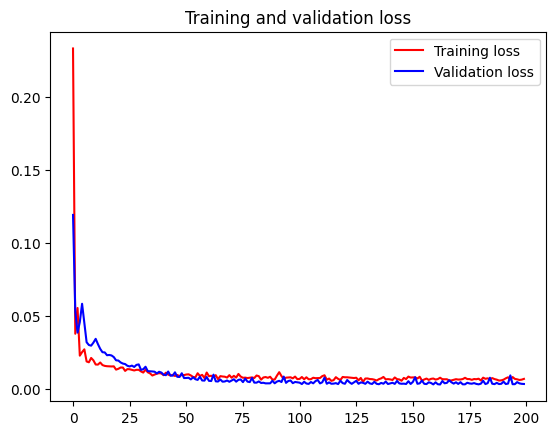

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 7ms/step


((133, 1), (84, 1))

**Model Evaluation**

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

**Evaluation metrices RMSE, MSE and MAE
.**
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  111.82270234047269
Train data MSE:  12504.316758725956
Train data MAE:  85.60515669055454
-------------------------------------------------------------------------------------
Test data RMSE:  101.31472143466162
Test data MSE:  10264.672779383083
Test data MAE:  77.21778157552086



The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.8815764155518959
Test data explained variance regression score: 0.9646064634733791


**R2 score for regression**
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best
0 or < 0 = worse

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8806353566136765
Test data R2 score: 0.9646022172800894


Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0002042139456562616
Test data MGD:  0.00016048148568662915
----------------------------------------------------------------------
Train data MPD:  1.596560919220409
Test data MPD:  1.2811431621814466


Comparision of original stock close price and predicted close price

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','Date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (249, 1)
Test predicted data:  (249, 1)


**Predicting next 30 days**

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 20
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))
lst_output

Output of predicted next days:  20


[[0.07205290347337723],
 [0.0879715234041214],
 [0.11136382818222046],
 [0.13569840788841248],
 [0.1601862758398056],
 [0.18461419641971588],
 [0.2088468074798584],
 [0.2327912151813507],
 [0.25637713074684143],
 [0.27954354882240295],
 [0.30223506689071655],
 [0.3243962228298187],
 [0.34597495198249817],
 [0.3669215738773346],
 [0.38718563318252563],
 [0.40671828389167786],
 [0.4254828691482544],
 [0.4434405565261841],
 [0.460559606552124],
 [0.4768139123916626]]

In [ ]:
Twenty_day_real_world_data=pd.read_csv("/content/March(1-30) NIFTY OIL & GAS_Data.csv")

In [ ]:
# Reverse rows using iloc() Function
Twenty_day_real_world_data = Twenty_day_real_world_data.loc[::-1].reset_index(drop=True)

Twenty_day_real_world_data

,Date,Open,High,Low,Close
0,01 Mar 2023,6949.20,7019.70,6937.85,7015.20
1,02 Mar 2023,7008.50,7045.55,6996.35,7017.65
2,03 Mar 2023,7074.70,7132.75,7063.55,7111.25
3,06 Mar 2023,7153.40,7278.40,7149.35,7247.75
4,08 Mar 2023,7248.90,7311.25,7225.65,7306.60
5,09 Mar 2023,7334.50,7336.65,7230.45,7239.90
6,10 Mar 2023,7206.40,7234.70,7152.45,7225.60
7,13 Mar 2023,7259.35,7286.35,7144.45,7164.30
8,14 Mar 2023,7145.05,7181.90,7102.05,7117.30
9,15 Mar 2023,7133.90,7148.95,7058.35,7076.50


In [ ]:
Twenty_day_real_world_data['Date'] = pd.to_datetime(Twenty_day_real_world_data.Date)
Twenty_day_real_world_data

,Date,Open,High,Low,Close
0,2023-03-01,6949.20,7019.70,6937.85,7015.20
1,2023-03-02,7008.50,7045.55,6996.35,7017.65
2,2023-03-03,7074.70,7132.75,7063.55,7111.25
3,2023-03-06,7153.40,7278.40,7149.35,7247.75
4,2023-03-08,7248.90,7311.25,7225.65,7306.60
5,2023-03-09,7334.50,7336.65,7230.45,7239.90
6,2023-03-10,7206.40,7234.70,7152.45,7225.60
7,2023-03-13,7259.35,7286.35,7144.45,7164.30
8,2023-03-14,7145.05,7181.90,7102.05,7117.30
9,2023-03-15,7133.90,7148.95,7058.35,7076.50


In [ ]:
Twenty_days_predict = scaler.inverse_transform(lst_output)
Twenty_days_predict

array([[7063.49866506],
       [7090.41864323],
       [7129.97736984],
       [7171.12957758],
       [7212.54101107],
       [7253.85106757],
       [7294.83083613],
       [7335.32322399],
       [7375.20936581],
       [7414.38609541],
       [7452.75972162],
       [7490.23645243],
       [7526.7282413 ],
       [7562.15107358],
       [7596.41962427],
       [7629.45128989],
       [7661.18408002],
       [7691.55232514],
       [7720.50235064],
       [7747.99000725]])

In [ ]:
Twenty_day_predict = pd.DataFrame(Twenty_days_predict,columns=['predict_close'])
Twenty_day_predict

,predict_close
0,7063.498665
1,7090.418643
2,7129.977370
3,7171.129578
4,7212.541011
5,7253.851068
6,7294.830836
7,7335.323224
8,7375.209366
9,7414.386095


In [ ]:



plotdf = pd.DataFrame({'Date': Twenty_day_real_world_data['Date'],
                       'original_close': Twenty_day_real_world_data['Close'],
                      'Twenty_days_predicted_close': Twenty_day_predict['predict_close']})
plotdf

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['Twenty_days_predicted_close']],
              labels={'value':'Stock price','Date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs Twenty_days predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
print("Explained variance regression score:", explained_variance_score(plotdf['original_close'],plotdf['Twenty_days_predicted_close']))

Explained variance regression score: -8.315223207545099
